In [186]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import joblib
warnings.filterwarnings("ignore")

In [197]:
df_train = pd.read_csv("data/train.csv", index_col="Customer ID")

In [198]:
numerical = [ 'Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Dependents', 'Credit Score', 'No. of Defaults', 'Property Age', 'Property Price', 'Loan Sanction Amount (USD)']
categorical = ['Gender','Income Stability', 'Profession', 'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Property ID', 'Property Type', 'Property Location', 'Co-Applicant', 'Has Active Credit Card']

In [199]:
df_train.replace(-999, np.nan, inplace=True)

In [200]:
df_train.dropna(inplace=True, subset=['Loan Sanction Amount (USD)'])
#df_train.dropna(inplace=True)

In [201]:
df_train = df_train[df_train['Loan Sanction Amount (USD)']!=0]

In [202]:
for col in numerical:
    col_median = df_train[col].median()
    df_train[col].fillna(col_median, inplace=True)

for col in categorical:
    col_mode = df_train[col].mode()[0]
    df_train[col].fillna(col_mode, inplace=True)

In [203]:
for col in numerical:
    z_col = "z_score_" + "_".join(col.split(" "))
    df_train[z_col] = zscore(df_train[col])
    col_mean = round(df_train[col].mean(), 2)
    df_train.loc[np.abs(df_train[z_col]) > 3, col] = col_mean
    df_train = df_train.drop([z_col], axis=1)

In [204]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21457 entries, C-36995 to C-33003
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         21457 non-null  object 
 1   Gender                       21457 non-null  object 
 2   Age                          21457 non-null  float64
 3   Income (USD)                 21457 non-null  float64
 4   Income Stability             21457 non-null  object 
 5   Profession                   21457 non-null  object 
 6   Type of Employment           21457 non-null  object 
 7   Location                     21457 non-null  object 
 8   Loan Amount Request (USD)    21457 non-null  float64
 9   Current Loan Expenses (USD)  21457 non-null  float64
 10  Expense Type 1               21457 non-null  object 
 11  Expense Type 2               21457 non-null  object 
 12  Dependents                   21457 non-null  float64
 13  Credit Score 

In [205]:
for col in ['Age','Dependents','Credit Score', 'No. of Defaults','Co-Applicant']:
    df_train[col] = df_train[col].round().astype(int)

In [206]:
df_train['Property Age'] = round(df_train['Property Age']/365.0,1)

In [207]:
df_processed = df_train.copy()
df_processed.reset_index(inplace=True)

In [208]:
categorical = ['Gender', 'Profession', 'Location', 'Expense Type 1', 
               'Expense Type 2', 'Has Active Credit Card', 
               'Property Location', 'Income Stability', 'Type of Employment']

le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical:
    df_processed[col] = le.fit_transform(df_processed[col])

In [209]:
for col in categorical:
    df_processed[col]=df_processed[col].astype(int)

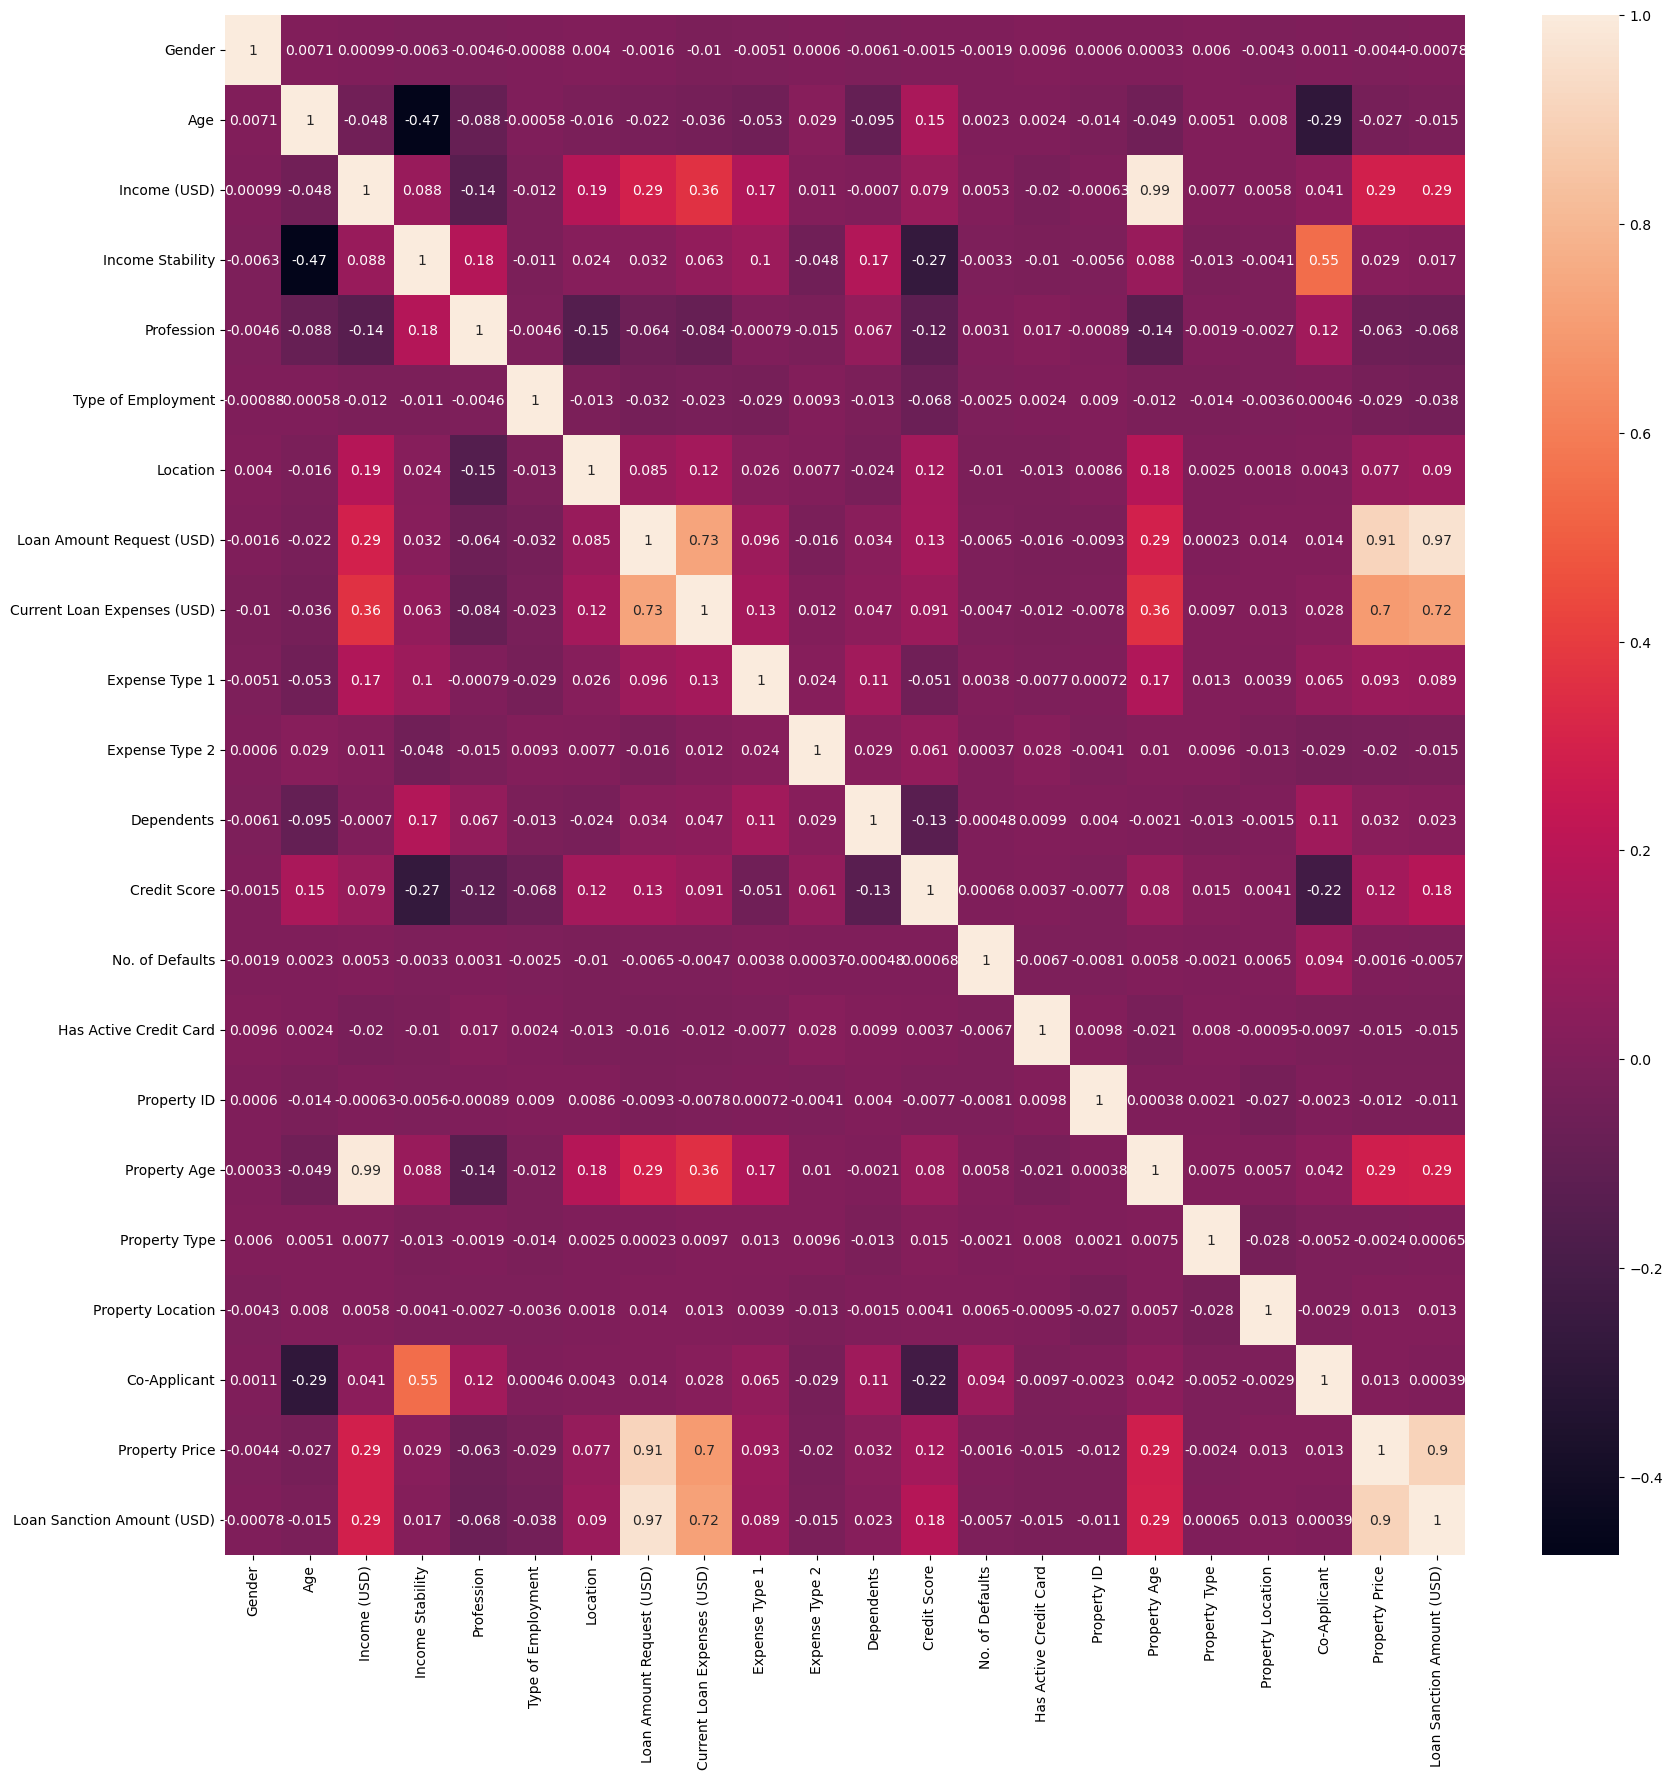

In [210]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_processed.corr(numeric_only = True), annot = True)
plt.show()

In [ ]:
#df_processed = df_processed[df_processed['Loan Sanction Amount (USD)']!=0]

In [211]:
drop_features = ['Customer ID','Name','Type of Employment','Property ID','Profession','Type of Employment']
df_processed.drop(drop_features, axis=1, inplace=True)

In [212]:
from scipy.stats import skew

def compute_skewness(df):
    # Select numerical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int32','int64']).columns
    
    # Compute skewness for each numerical column
    skew_values = {col: skew(df[col].dropna()) for col in numerical_cols}
    
    # Convert to DataFrame for better readability
    skew_df = pd.DataFrame(list(skew_values.items()), columns=['Column', 'Skewness'])
    skew_df.sort_values(by='Skewness', ascending=False, inplace=True)
    
    return skew_df
 
 # Get skewness values for each column
skew_df = compute_skewness(df_processed)
print(skew_df)

                         Column  Skewness
13                 Property Age  4.909945
2                  Income (USD)  4.839327
11              No. of Defaults  1.550198
17               Property Price  0.958407
18   Loan Sanction Amount (USD)  0.921456
5     Loan Amount Request (USD)  0.897062
6   Current Loan Expenses (USD)  0.722994
7                Expense Type 1  0.606945
9                    Dependents  0.600909
12       Has Active Credit Card  0.125237
10                 Credit Score  0.095595
14                Property Type  0.052232
15            Property Location  0.050398
1                           Age  0.032090
0                        Gender -0.011465
4                      Location -0.068528
8                Expense Type 2 -0.785390
3              Income Stability -2.662100
16                 Co-Applicant -4.156368


In [213]:
# Columns with skewness to handle
columns_to_transform = ['Property Age', 'Income (USD)', 'No. of Defaults']

# Log Transformation
df_processed['Property Age'] = np.log1p(df_processed['Property Age'])  
df_processed['Income (USD)'] = np.log1p(df_processed['Income (USD)'])

# Square Root Transformation for moderate skewness
df_processed['No. of Defaults'] = np.sqrt(df_processed['No. of Defaults'])

In [214]:
X, y = df_processed.iloc[:, :-1], df_processed.iloc[:, -1]

y = y.values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)  

y_train_scaled = scaler_Y.fit_transform(y_train)
y_val_scaled = scaler_Y.transform(y_val)
y_test_scaled = scaler_Y.transform(y_test)

In [215]:
param_grid = {
    'n_estimators': [100, 300],   
    'max_depth': [None, 10, 15],      
    'min_samples_split': [2, 5, 3],  
    'min_samples_leaf': [1, 2],    
    'max_features': ['log2', 'sqrt',None]  
}

model = RandomForestRegressor(random_state=42)


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,  
    verbose=2,
    n_jobs=-1 
)

grid_search.fit(X_train_scaled, y_train_scaled.ravel())

best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print(f"Best parameter values: {best_params}")
print(f"MSE using best model: {best_mse:.2f}")

joblib.dump(grid_search.best_estimator_, 'random_forest_model.pkl')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameter values: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
MSE using best model: 0.04


['random_forest_model.pkl']

In [216]:
joblib.dump(scaler_Y, 'scaler.pkl')

['scaler.pkl']